# Pairs Trading selection framework

## Introduction 

Pairs trading is a relative value investment strategy which trades related assets by using statistical arbitrage.
The basic idea behind pairs trading is that assets are in a long-run equilibrium. 
When these assets deviate from this equilibrium in the short term, a profit can be made by shorting one asset and buying the other asset and spread between will converge. In essence it is based on the notation that cointegrated pairs are mean reverting.

Before you start pairs trading, you first need to select related assets to trade.
Finding suitable pairs can be quite a challenge since there are a lot assets to pick and choose from. 
This notebook demonstrates an implementation of how to select possible pairs that are suitable to trade.
The framework to select these assets is based the paper *Enhancing a Pairs Trading strategy
with the application of Machine Learning* by Sarmento and Horta (2020).

The proposed framework to select these assets is given in following three steps:
1. Dimensionality reduction
2. Unsupervised Learning clustering
3. Pairs selection criteria



To start off we select first a universe of stocks prices and and calculate their returns.
It is important to keep in mind the length of the period of the stocks and their granularity.


In [1]:
import pandas as pd
import pairs_selection_framework
import plotly.io as pio

pairs_clust = pairs_selection_framework.PairsClustering()

df_prices = pd.read_csv('us_stocks_price')
df_prices = df_prices.set_index('Date')
df_returns = pd.DataFrame.dropna(df_prices.pct_change())


##  1. Dimensionality reduction

If we have a large amount of stocks to choose from we, have a very high dimensional data set that we need to evaluate. Analyzing such data to leads to the curse of dimensionality, which is a phenomenom that appears when analyzing data in high dimensions which causes problems for statistical analyses. We therefore need a technique to represent the data in a more compact way. A technique commonly used to achieve this **Principal Components Analysis** (PCA).

PCA is a dimensionality reduction method that is often used to reduce the dimensionality of large data sets, by transforming a large set of variables into a smaller set that still contains most of the information from the original data. PCA uses orthogonal transformations to convert a set of observations of variables that are possibly correlated into into variables that are linearly uncorrelated. These uncorrelated variables are called principal components and are compact represents of the original variables that explains as much as possible variation of the data in the first few principal components.Stock return rather than stock prices should be used when applying PCA otherwise spurios relationships could be deteced due to time trends.

Lets start off with plotting the percentage of variance explained for each additional principal component.

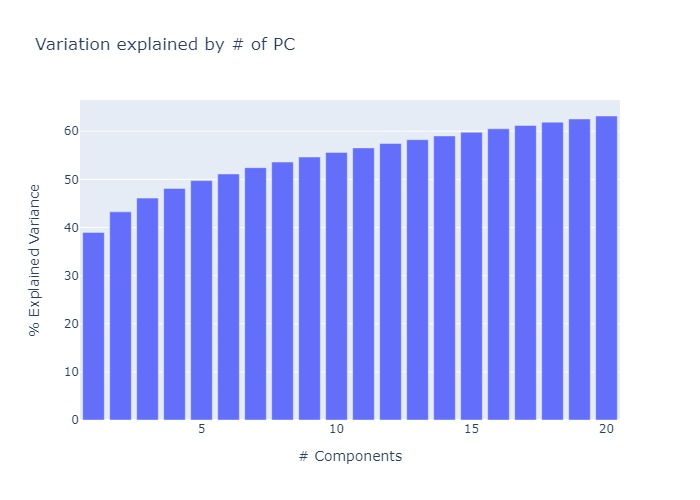

In [10]:
#render graphs so that they display when saving jupyter notebook
pio.renderers.default = "jpeg"

# Plot the variation explained by the principal components.
pairs_clust.plot_pca_explained_variation(df_returns)

We can see from graph that the first principal compoents explains almost 40% of the variation in the data. We proceed by choosing 10 principal components to use as there is little increase in the variation explained in the data as the number of principal components increases and we want low dimensional data to work with. We not calculate the principal components, given that we use 10.

In [3]:
# select number of principal components   
principal_components  = pairs_clust.principal_components_vectors(df_returns,10)

## 2. Unsupervised learning clustering

Now that we have a compact representation of that data we can use unsupervised learning techniques to cluster the data.
The proposed technique for this is the **Ordering points to identify the clustering structure** (OPTICS) algorithm. This a algorithm for finding density-based clusters in spatial data. The basic idea is that the algorithm orders based on reachability distance of the sample points while expanding the clusters at the same time. The output of the OPTICS algorithm is therefore an ordered list of reachability distances, which by means of thresholds or different techniques we can split into clusters.The algorithm takes two arguments:
- $ \epsilon $    :The maximum distance between two samples for one to be consider in the neighborhood of the other.
- *minPts* : The minimum number of points to form a cluster

We now apply this algorithm by using the principal components previously calculated to find clusters of stocks. We choose the minimum number of samples to form a cluster and the maximum distance as 1. These values can be adjusted to see different results.

In [4]:
# apply optics algorithm
clustered_numbers, clustered_numbers_all , grouped_clusters = pairs_clust.cluster_OPTICS(principal_components, 
                                                               df_returns, min_samples =3 , max_eps=1)
# print the clusters discovered
print('Stocks per cluster:')
print(grouped_clusters)

Number of pairs to evalute is 219
Clusters discovered: 21
Stocks per cluster:
    Cluster                                            Tickers  Count
1         1                           [AAPL, MSFT, SNPS, CDNS]      4
2         2                      [V, MA, ACN, SPGI, FISV, FIS]      6
3         3         [HD, NKE, LOW, SBUX, ADP, SHW, PAYX, ORLY]      8
4         4                                    [LIN, IBM, APD]      3
5         5                             [RY, TD, BNS, BMO, CM]      5
6         6                      [UNP, HON, DE, CSX, NSC, JCI]      6
7         7                                [LMT, WM, PGR, NOC]      4
8         8                                 [PG, PEP, CL, KMB]      4
9         9                                    [PFE, MRK, BMY]      3
10       10                                    [ABT, BDX, BAX]      3
11       11  [JPM, WFC, SCHW, GS, PNC, USB, TFC, COF, MET, BK]     10
12       12                               [UNH, ANTM, CI, HUM]      4
13       13 

We can see that the OPTICS algorithm  discovered 21 clusters and that there are 219 pairs to evaluate.



### Visualizing clusters

Now that we have the clusters we can  also visually inspect the clusters. This is done through a *T-Distrbuted Stochastic Neighbour Embedding*. A TSNE graph takes high dimensional data and aims to represent it in a 2-D graph. This is shown below.

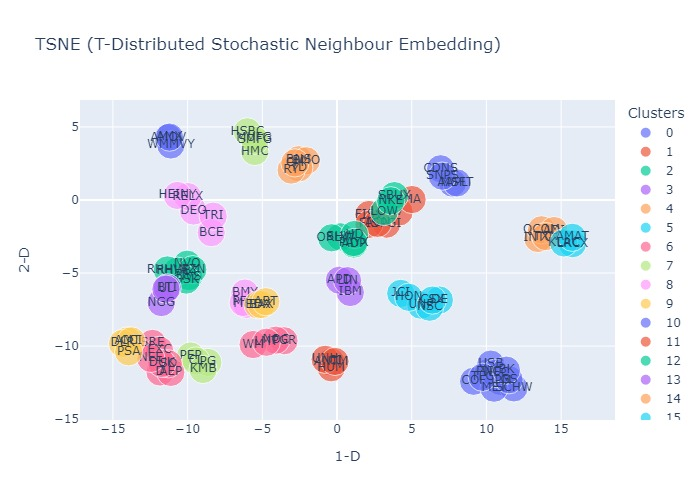

In [5]:
pairs_clust.plot_TSNE(principal_components , clustered_numbers, clustered_numbers_all)

## 3. Pairs selection criteria

Having generated the clusters of assets, we still need to find pairs of stock that are suitable for trading. The framework proposes using the following four conditions to check for suitable pairs.
1. Cointergration:Cointegration tests identify scenarios where two or more non-stationary time series are integrated together in a way that they cannot deviate from equilibrium in the long term. The tests are used to identify the degree of sensitivity of two variables to the same average price over a specified period of time.

2. Hurst exponent test: The Hurst exponent is a measure of long-term memory of time series. Used to check if is a series is mean-reverting (<0.5) ,  random walk (=0.5) or treding (>5). In our case we shoud specify the hurst threshold as lower than 0.5 so that it is mean reverting
.
3. Half life: The half-life measures how long it would take a time series to revert back to half it’s initial deviation away from the mean. we can specify a maxium value so that the spread does not take to long to converge, and a minimum value so that the spread does not converge to quickly. We can specify for example 250 so that is reverts at least yearly.

4. Spread crossings: Measure to test how many times the spread is crossed (across zero) for the testing period. We want a least a minium number of times that the spread crosses zero in order for us to trade the pairs. Say we want the spread to cross at least quartlery then we can specify this parameter as 4*(years of data)

We can implement these criteria and find candidate pairs to trade as follows:

In [6]:
pairs_select =  pairs_selection_framework.PairSelectionCriteria()
conditions_met , number_conditions, possible_pairs , spreads = pairs_select.pair_conditions_check(
                                                                                grouped_clusters,df_prices , max_half_life = 250,
                                                                                min_spread_crosses =48)

Now that we have implemented this we can check which pairs satisfy all the criteria and how many passed each condition.

In [7]:
print("There are {} ".format(len(possible_pairs)) + "pairs that met all the criteria")
print("The following pairs are suitable for pairs trading:")
print(possible_pairs)

print('Number of pairs that passed each test:')
print(number_conditions)

There are 77 pairs that met all the criteria
The following pairs are suitable for pairs trading:
[('AAPL', 'SNPS'), ('MSFT', 'SNPS'), ('MSFT', 'CDNS'), ('SNPS', 'CDNS'), ('ACN', 'SPGI'), ('FISV', 'FIS'), ('HD', 'ADP'), ('HD', 'SHW'), ('HD', 'PAYX'), ('HD', 'ORLY'), ('NKE', 'LOW'), ('NKE', 'SBUX'), ('NKE', 'ADP'), ('NKE', 'SHW'), ('NKE', 'PAYX'), ('NKE', 'ORLY'), ('LOW', 'ADP'), ('LOW', 'SHW'), ('LOW', 'PAYX'), ('LOW', 'ORLY'), ('SBUX', 'ORLY'), ('ADP', 'SHW'), ('ADP', 'PAYX'), ('ADP', 'ORLY'), ('SHW', 'PAYX'), ('SHW', 'ORLY'), ('PAYX', 'ORLY'), ('RY', 'TD'), ('RY', 'BNS'), ('RY', 'BMO'), ('RY', 'CM'), ('TD', 'BNS'), ('TD', 'BMO'), ('TD', 'CM'), ('BNS', 'BMO'), ('BNS', 'CM'), ('BMO', 'CM'), ('CSX', 'NSC'), ('LMT', 'NOC'), ('WM', 'PGR'), ('CL', 'KMB'), ('JPM', 'PNC'), ('JPM', 'TFC'), ('JPM', 'MET'), ('SCHW', 'GS'), ('SCHW', 'PNC'), ('SCHW', 'TFC'), ('SCHW', 'COF'), ('SCHW', 'MET'), ('SCHW', 'BK'), ('GS', 'COF'), ('GS', 'MET'), ('PNC', 'TFC'), ('PNC', 'COF'), ('PNC', 'MET'), ('TFC', 'MET'

As a last measure we can inspect the plot of the adjusted log prices and the spread between the log prices to see how some of the pairs of stocks are related to each other.

[('MSFT', 'CDNS'), ('SNPS', 'CDNS'), ('ACN', 'SPGI')]


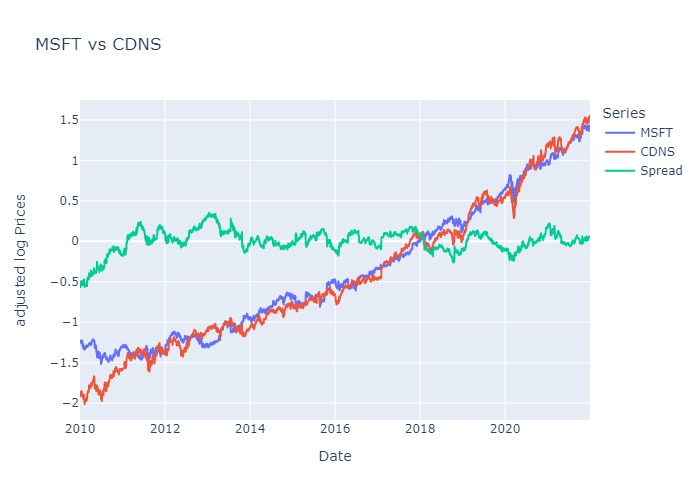

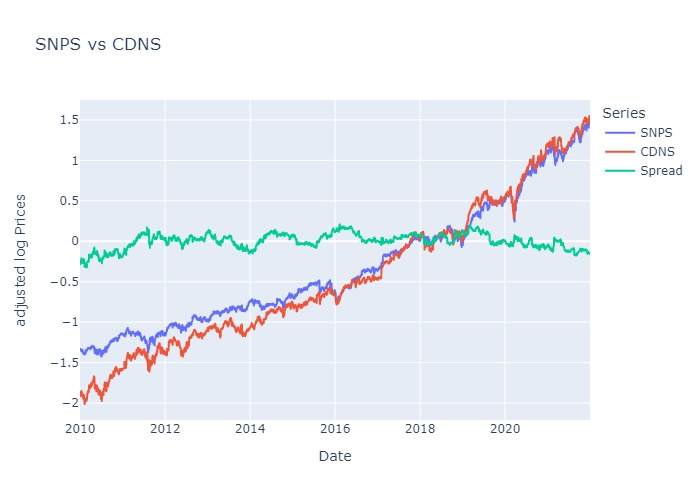

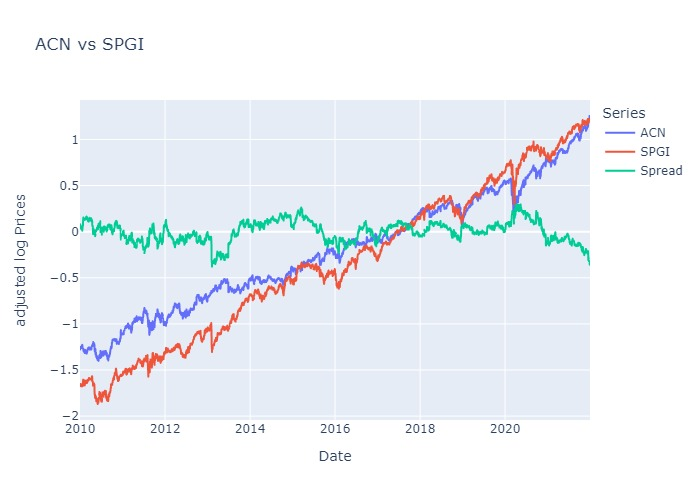

In [9]:
pairs_selected = possible_pairs[2:5]
print(pairs_selected)
pairs_select.plot_pairs(pairs_selected ,df_prices, spreads)

## Conclusion

Using the the proposed framework we have found 77 pairs of stocks to trade from the universe of stocks selected. Initially there were more than 30 000 pairs to evaluate but by using machine learning techniques this has been narrowed down quite a bit. Different values can be used to manually inspect different results. The next step is now to rank these pair according to some metric and find a profitable trading strategy

### Refrences

'*Enhancing a Pairs Trading strategy with the application of Machine Learning*',  (Saramento et al,2020)